## Encode chess position

In [1]:
from lib.dataset_utils import encode_position, store_many_hdf5
from lib.score_getter import ScoreGetter, Engine

import chess
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import current_process

We load a dataset containing millions of unique chess position represented by the [FEN](https://fr.wikipedia.org/wiki/Notation_Forsyth-Edwards) notation.

In [2]:
df = pd.read_csv("/media/gaetan/HDD/IA/Chess/Datasets/fen_dataset.csv")
df = df.sample(frac=1)

We create our train/test dataset.

Each position is encoded as an image of $8\times8$ "pixels" with $15$ channels
($12$ representing each chess pieces, $1$ for the actual player, $1$
for the en-passant square and $1$ for the castling rights). Along this encoded position, we store
the score given by Stockfish 14.

In [3]:
directory = "/media/gaetan/HDD/IA/Chess/Datasets/SE_ResNet/"

score_getter = ScoreGetter("bin/stockfish", Engine.STOCKFISH)

nb_positions = 3_400_000
save_step = 1_000_000

# Status bar configuration
current = current_process()
pos = current._identity[0]-1 if len(current._identity) > 0 else 0
pbar = tqdm(total=nb_positions, desc="Encoding", position=pos)

positions = []
scores = []
for i in range(nb_positions):
  pbar.update(1)
  fen = df["board"][i]6
  board = chess.Board(fen)
  if board.is_game_over(): continue
  try:
      scores.append(score_getter.get_score(board.fen()))
      positions.append(encode_position(board))
  except Exception as e:
    if str(e) == "[Errno 32] Broken pipe":
        score_getter.restart()
    continue
  
  if (i+1) % save_step == 0:
    store_many_hdf5(positions, scores, directory, tag=f"_{i//save_step}")
    positions = []
    scores = []

store_many_hdf5(positions, scores, directory, tag=f"_{i//save_step}")


Encoding: 100%|█████████▉| 3399987/3400000 [2:48:29<00:00, 333.93it/s]   

We save the resulting dataset using HDF5.

In [4]:
print(f"Number of positions: {len(positions)}")

Number of positions: 396798


We look at the distribution of the scores

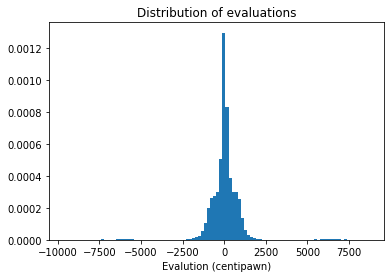

In [5]:
plt.hist(scores, bins=100, density=True)
plt.xlabel("Evalution (centipawn)")
plt.title("Distribution of evaluations")
_ = plt.savefig("results/distribution.pdf")

In [6]:
pd.Series(scores).describe()

count    396798.000000
mean         30.376353
std         919.320381
min       -9616.000000
25%        -254.000000
50%          29.000000
75%         329.000000
max        8666.000000
dtype: float64

Encoding: 100%|██████████| 3400000/3400000 [2:48:40<00:00, 333.93it/s]